In [1]:
import matplotlib
import data_collector as dc
import pandas as pd
import pathlib
import urllib.request
import geopandas as gpd
import ipywidgets as widgets

In [5]:
# Just exploring some local level data pulls
# **** Remove?
#test = dc.pull_demo_data(_)
#df = pd.DataFrame(test.json())

# load data
states_file_name= "tl_2017_us_state.zip"
states_url = f"https://www2.census.gov/geo/tiger/TIGER2017/STATE/{states_file_name}"
states_file = pathlib.Path(states_file_name)

#puma_file_name = []
#puma_url = []
#puma_file = []

#for i in range(77,78):
#    if i <=8:
#        str_num = '0'+str(i+1)
#    else:
#        str_num = str(i+1)
#    f_name = str("tl_2017_"+str_num+"_puma10.zip")
#    puma_file_name.append(f_name)
#    puma_url.append(f"https://www2.census.gov/geo/tiger/TIGER2017/PUMA/{f_name}")
#    puma_file.append(pathlib.Path(f_name))

zipcode_file_name = "tl_2017_us_zcta510.zip"
zipcode_url = f"https://www2.census.gov/geo/tiger/TIGER2017/ZCTA5/{zipcode_file_name}"
zipcode_file = pathlib.Path(zipcode_file_name)

county_file_name = 'tl_2017_us_county.zip'
county_url = f"https://www2.census.gov/geo/tiger/TIGER2017/COUNTY/{county_file_name}"
county_file = pathlib.Path(county_file_name)

metro_file_name = 'tl_2017_us_cbsa.zip'
metro_url = f"https://www2.census.gov/geo/tiger/TIGER2017/CBSA/{metro_file_name}"
metro_file = pathlib.Path(metro_file_name)

#for data_file, url in zip(puma_file,puma_url):
#    print(data_file)
#    print(url)
#    if not data_file.is_file():
#        with urllib.request.urlopen(url) as resp, open(data_file, "wb") as f:
#            f.write(resp.read())


#puma_gdf = gpd.read_file(f"zip://{puma_file[0]}")


In [7]:
import os
import re

puma_gdf_list = []
for file_name in os.listdir('./'):
    if 'puma' in file_name:
        puma_gdf_list.append(gpd.read_file(f"zip://{pathlib.Path(file_name)}"))
puma_gdf = pd.concat(puma_gdf_list, axis=0, ignore_index=True)
states_gdf = gpd.read_file(f"zip://{states_file}")
county_gdf = gpd.read_file(f"zip://{county_file}")
metro_gdf = gpd.read_file(f"zip://{metro_file}")

In [8]:
metro_xls_df = pd.ExcelFile('./metropolitan_data_Sep_2018.xls')
metro_xls_df.sheet_names
metro_df = metro_xls_df.parse('List 1')

In [9]:
header = ['CBSA_Code','Metro_Div_Code','CSA_Code','CBSA_Title','MSA','Metr_Div_Title','CSA_Title','County','State','FIPS_State_Code','FIPS_County_Code','Central_Outlying_County']
metro_df = metro_df[2:]
metro_df.columns = header

In [10]:
states = metro_df['State'].unique()
states = [x for x in states if str(x) != 'nan']
selected_state = widgets.Dropdown(options=sorted(states))

In [52]:
selected_state

Dropdown(index=21, options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut…

In [53]:
metro_df[metro_df.State==selected_state.value].iloc[2]
state_code = metro_df[metro_df.State==selected_state.value]['FIPS_State_Code'].iloc[0]

In [54]:
metro = metro_df[metro_df.State==selected_state.value]['CBSA_Title'].unique()
metro = [x for x in metro if str(x) != 'nan']
selected_metro = widgets.Dropdown(options=metro)

In [55]:
selected_metro

Dropdown(options=('Barnstable Town, MA', 'Boston-Cambridge-Newton, MA-NH', 'Pittsfield, MA', 'Providence-Warwi…

In [56]:
metro_code = metro_df[metro_df.CBSA_Title == selected_metro.value]['CBSA_Code'].iloc[0]

In [57]:
#cbsa_gdf[cbsa_gdf.CBSAFP==metro_code]
counties = metro_df[metro_df.CBSA_Code==metro_code]['County'].unique()

In [58]:
#greenville_puma_lst = []
#for puma in town.greenville_sc:
#    greenville_puma_lst.append(puma_gdf[puma_gdf['PUMACE10'] == puma])
county_lst = []
for county in counties:
    county_lst.append(county_gdf[(county_gdf['NAMELSAD']==county) & (county_gdf['STATEFP']==state_code) ]) 
state_map = states_gdf[states_gdf['NAME'] == selected_state.value]
city_map = metro_gdf[metro_gdf['CBSAFP']==metro_code]

<IPython.core.display.Javascript object>


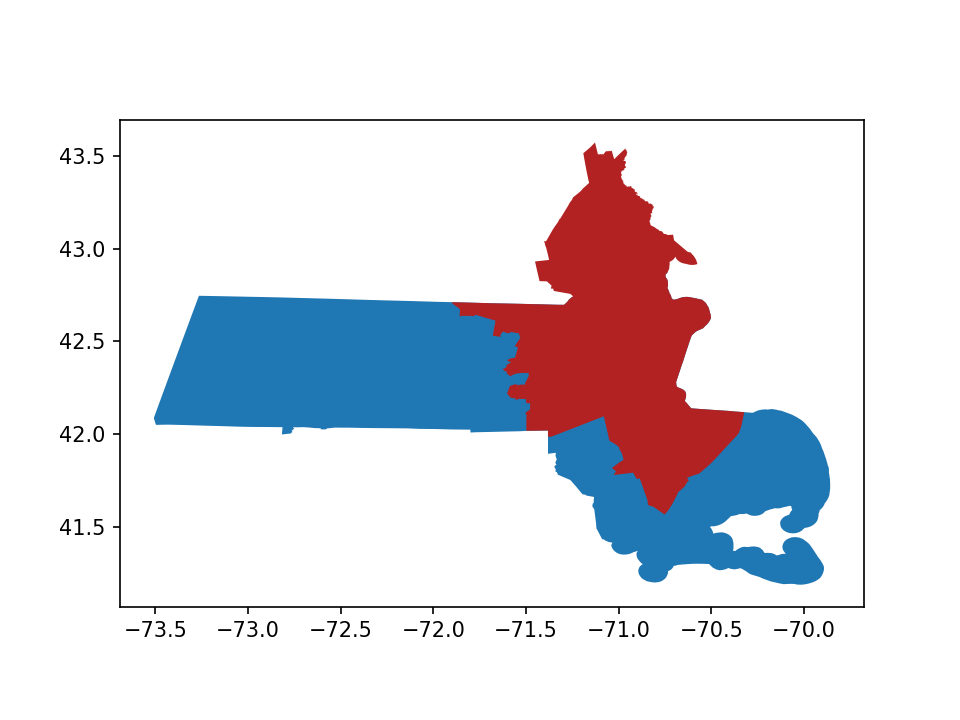

In [59]:
%matplotlib notebook
base = state_map.plot()
color_cycle = ['lightcoral','firebrick','red','greenyellow','palegreen','lawngreen']*100
city_map.plot(ax=base,color=color_cycle[1])

<IPython.core.display.Javascript object>


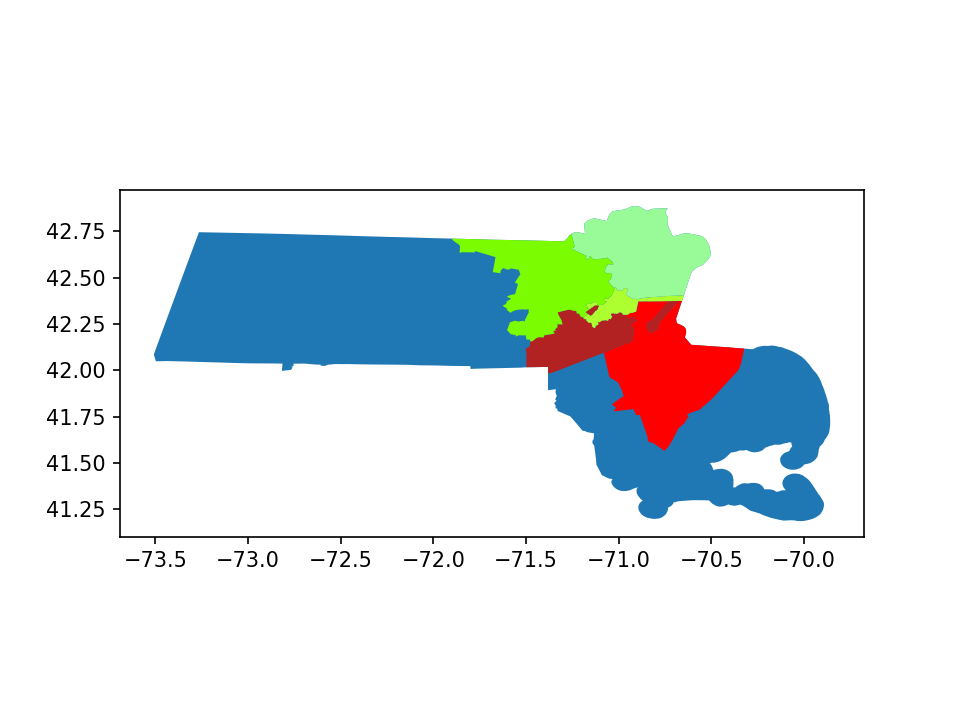

In [61]:
%matplotlib notebook
base = state_map.plot()
color_cycle = ['lightcoral','firebrick','red','greenyellow','palegreen','lawngreen']*100
for i,county in enumerate(county_lst):
    county.plot(ax=base,color=color_cycle[i+1])

In [62]:
#%matplotlib notebook
#base = city_map.plot()
#pyplot.set_cmap('hot')
#color_cycle = ['lightcoral','firebrick','red','greenyellow','palegreen','lawngreen']*100
#for i,county in enumerate(county_lst):
#    county.plot(ax=base,color=color_cycle[i])

In [63]:
metro_names = selected_metro.value[:-4].split('-')
conditional_str = ''
for city in metro_names:
    conditional_str += city+'|'
for county in counties:
    conditional_str += county[:-7]+'|'

<IPython.core.display.Javascript object>


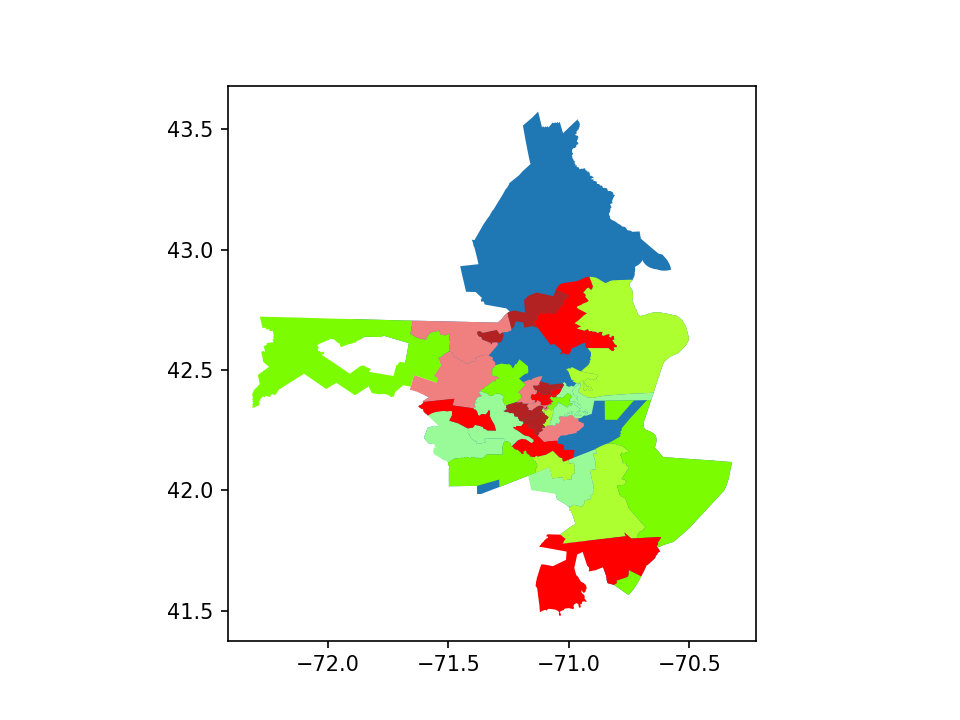

In [64]:
%matplotlib notebook
df = puma_gdf[(puma_gdf['STATEFP10']==state_code) & puma_gdf['NAMELSAD10'].str.contains(conditional_str[:-1], regex=True)]
base = city_map.plot()
color_cycle = ['lightcoral','firebrick','red','greenyellow','palegreen','lawngreen']*100
j=0
for i,county in df.iterrows():
    county_df = df[j:j+1]
    j+=1
    county_df.plot(ax=base,color=color_cycle[i%(len(color_cycle))])   